This notebook is divided into the following parts
1. Data cleaning
2. Data Analysis
3. Build Recommender system
4. Evaluation of recommender system

First we make the required imports

In [1]:
#data analysis libraries 
import numpy as np
import pandas as pd

#visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS #used to generate world cloud
%matplotlib inline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
#ignore warnings
import warnings
warnings.filterwarnings('ignore')


Defaulting to user installation because normal site-packages is not writeable


Now we import all the datasets

We consider all datasets except for the link dataset

Currently my test is on small dataset. I will replace this with the biggger dataset finally

In [2]:
movies = pd.read_csv('./Downloads/ml-latest/movies.csv')
ratings = pd.read_csv('./Downloads/ml-latest/ratings.csv')
tags = pd.read_csv('./Downloads/ml-latest/tags.csv')

In [3]:
print(movies.head())
print(ratings.head())
print(tags.head())

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
   userId  movieId  rating   timestamp
0       1      307     3.5  1256677221
1       1      481     3.5  1256677456
2       1     1091     1.5  1256677471
3       1     1257     4.5  1256677460
4       1     1449     4.5  1256677264
   userId  movieId           tag   timestamp
0      14      110          epic  1443148538
1      14      110      Medieval  1443148532
2      14      260        sci-fi  14

**Part 1: Cleaning the data**

First, we need to check if for 'null' values in the dataset

In [4]:
print(movies.isnull().any())
print(ratings.isnull().any())
print(tags.isnull().any())

movieId    False
title      False
genres     False
dtype: bool
userId       False
movieId      False
rating       False
timestamp    False
dtype: bool
userId       False
movieId      False
tag           True
timestamp    False
dtype: bool


My current dataset does not have null values but I will just write the cleaning statements just in case there are null values in the bigger dataset

In [5]:
movies = movies.dropna()
ratings = ratings.dropna()
tags = tags.dropna()

Extract year from the movie title for analysis

In [6]:
movies['year'] = movies['title'].str.extract('\((\d{4})\)',expand = False)
movies['year'].describe()

count     57771
unique      134
top        2015
freq       2312
Name: year, dtype: object

In [7]:
movies.describe()

,movieId
count,58098.000000
mean,111919.516197
std,59862.660956
min,1.000000
25%,72437.750000
50%,126549.000000
75%,161449.500000
max,193886.000000


From the above comparision we can see there is some discrepancy in the year column wrt whole dataset

In [8]:
movies[movies['year'].isnull()]

,movieId,title,genres,year
10023,32930,Category 6: Day of Destruction,Action|Drama,NaN
10613,40697,Babylon 5,Sci-Fi,NaN
15719,79607,"Millions Game, The (Das Millionenspiel)",Action|Drama|Sci-Fi|Thriller,NaN
17444,87442,"Bicycle, Spoon, Apple (Bicicleta, cullera, poma)",Documentary,NaN
22651,107434,Diplomatic Immunity (2009– ),Comedy,NaN
...,...,...,...,...
57504,192339,The Sign of Three,(no genres listed),NaN
57674,192829,Parwaaz Hai Junoon,Adventure|Children|Romance,NaN
57789,193149,¿Qué te juegas?,(no genres listed),NaN
57903,193443,Wall,(no genres listed),NaN


This has given us 2 insights 
1. That some of the movies do not have proper year
2. Some of the movies do not have proper genre

We are going to remove movies without genres to make our dataset more robust

In [9]:
movies = movies[movies['genres'] != '(no genres listed)']
movies = movies.dropna()
movies.describe()

,movieId
count,53717.000000
mean,108312.277789
std,60581.365654
min,1.000000
25%,65930.000000
50%,121457.000000
75%,159725.000000
max,193886.000000


Now we should clean the genres

In [10]:
# Get new columns with genre names and put 0/1
# Step 1 get all unique generes from the column
# Step 2 add column for all unique genre
# Step 3 for each new column add 1 if the move belongs to that genre
temp = movies['genres'].str.get_dummies('|')
movies = movies.join(temp)
movies.head()

,movieId,title,genres,year,Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,1995,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


Can we remove some of the less useful genre? We would need analysis of "genre-rating" to figure that out

In [11]:
print(movies.iloc[:,4:29].sum())

Action          7114
Adventure       4058
Animation       2661
Children        2744
Comedy         15938
Crime           5099
Documentary     5082
Drama          24105
Fantasy         2632
Film-Noir        364
Horror          5543
IMAX             197
Musical         1112
Mystery         2770
Romance         7407
Sci-Fi          3434
Thriller        8199
War             1820
Western         1378
dtype: int64


Now we merge the tags dataframe with the ratings dataframe. This will help us to analyze tag and ratings analysis

But first, we drop the timestamp columns since they do not seem useful to us

In [12]:
tag = tags.iloc[:,0:3]
rating = ratings.iloc[:,0:3]
ratings_and_tags = pd.merge(rating, tag , on=['userId','movieId'])
ratings_and_tags.head(10)

,userId,movieId,rating,tag
0,14,110,4.5,epic
1,14,110,4.5,Medieval
2,14,318,4.5,imdb top 250
3,14,318,4.5,justice
4,14,480,4.5,Dinosaurs
5,14,593,4.5,psychothriller
6,14,1682,4.0,philosophy
7,14,1682,4.0,surveillance
8,14,7458,4.0,Epic
9,14,95311,4.5,Pixar


We might also need to merge movies and ratings to find relationship of genres and ratings

In [13]:
#Merge the 2 dataframes based on movie id's, this creates cross products and we have duplicate movieIds
ratings_and_movies = pd.merge(movies, rating, on=['movieId'])
# Claculate mean and median ratings of each movie
ratings_and_movies['mean_rating'] = ratings_and_movies.groupby(['movieId'])['rating'].transform('mean')
# remove multiple entries for the same movieid, we also don't need the rating column now
ratings_and_movies.drop_duplicates(subset=['movieId'], inplace=True)
ratings_and_movies.drop(columns=['rating','userId'], inplace=True)
ratings_and_movies.reset_index(inplace=True, drop=True)
ratings_and_movies.head(20)

#Since we have duplicate values it would be better just to keep  the mean and median value of ratings


,movieId,title,genres,year,Action,Adventure,Animation,Children,Comedy,Crime,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,mean_rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,3.886649
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,3.246583
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,3.173981
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,2.874540
4,5,Father of the Bride Part II (1995),Comedy,1995,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,3.077291
5,6,Heat (1995),Action|Crime|Thriller,1995,1,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,3.844211
6,7,Sabrina (1995),Comedy|Romance,1995,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,3.371348
7,8,Tom and Huck (1995),Adventure|Children,1995,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,3.122482
8,9,Sudden Death (1995),Action,1995,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.007530
9,10,GoldenEye (1995),Action|Adventure|Thriller,1995,1,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,3.431633


In [14]:
# Tag + Movies dataset
tags_and_movies = pd.merge(tags, movies, on=['movieId'], how='inner')
tags_and_movies

,userId,movieId,tag,timestamp,title,genres,year,Action,Adventure,Animation,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,14,110,epic,1443148538,Braveheart (1995),Action|Drama|War,1995,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,14,110,Medieval,1443148532,Braveheart (1995),Action|Drama|War,1995,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,815,110,overrated,1150006110,Braveheart (1995),Action|Drama|War,1995,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3,2577,110,Oscar (Best Picture),1378324225,Braveheart (1995),Action|Drama|War,1995,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4,3086,110,epic,1463675332,Braveheart (1995),Action|Drama|War,1995,1,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1099903,282119,164453,engineer,1475084794,Failure of Engineer Garin (1973),Adventure|Drama|Sci-Fi|Thriller,1973,0,1,0,...,0,0,0,0,0,0,1,1,0,0
1099904,282119,164453,soviet classics,1475084778,Failure of Engineer Garin (1973),Adventure|Drama|Sci-Fi|Thriller,1973,0,1,0,...,0,0,0,0,0,0,1,1,0,0
1099905,283000,91960,Amazingly Bad,1337484461,"Magic Christmas Tree, The (1964)",Children|Comedy|Fantasy,1964,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1099906,283000,91960,Effeminate Tree,1337484484,"Magic Christmas Tree, The (1964)",Children|Comedy|Fantasy,1964,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
# Movies + Rating + tag dataset
tags_and_ratings = pd.merge(tags, ratings, on=['movieId', 'userId'], how='inner')
combined = pd.merge(tags_and_ratings, movies, on=['movieId'], how='inner')
combined.columns.values

array(['userId', 'movieId', 'tag', 'timestamp_x', 'rating', 'timestamp_y',
       'title', 'genres', 'year', 'Action', 'Adventure', 'Animation',
       'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
       'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance',
       'Sci-Fi', 'Thriller', 'War', 'Western'], dtype=object)

**Part 2: Data Analysis**

In this part we want to answer the following Questions which will help us build our recommender system

1. What is the relationship between genre and rating of a movie?
2. What is the relationship between year and rating of a movie?
3. What is the relationship between tag and ratings of a movie?
4. What is the relationship between tag + genre and ratings of a movie?
5. Are there any sparse "genre" that we can discard to make our system efficient?
6. What of the above features discussed are valuable to our recommendation system? 

Relationship between Genres and movie ratings

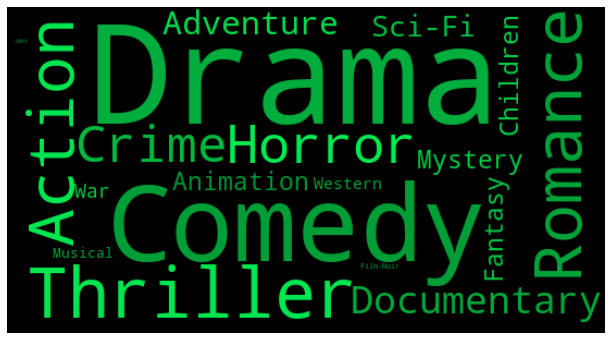

In [16]:
# First we see contribution of genre 
words = movies.iloc[:,4:29].sum().to_dict()
tone = 100

# Function that control the color of the words
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

f, ax = plt.subplots(figsize=(14, 6))
wordcloud = WordCloud(width=550,height=300, background_color='black', 
                      max_words=1628,relative_scaling=0.7,
                      color_func = random_color_func,
                      normalize_plurals=False)
wordcloud.generate_from_frequencies(words)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

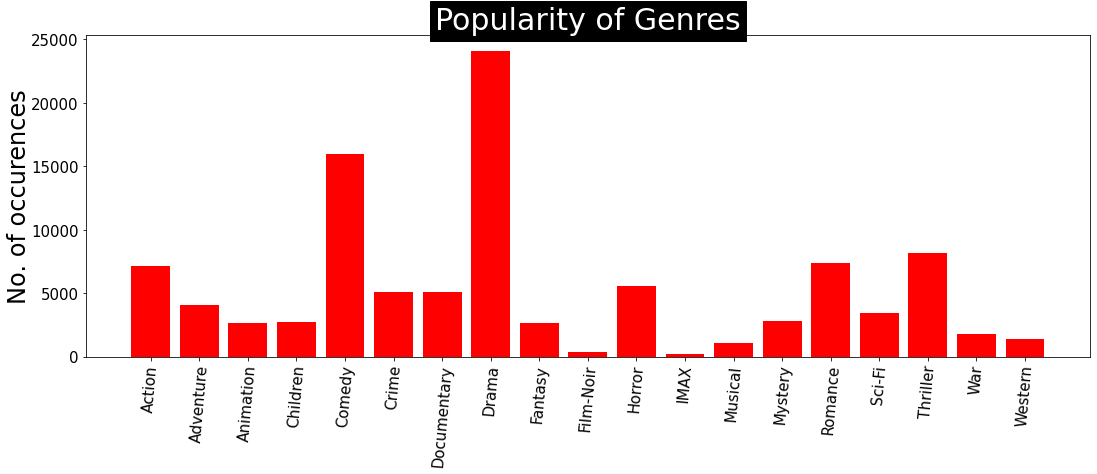

dict_values([7114, 4058, 2661, 2744, 15938, 5099, 5082, 24105, 2632, 364, 5543, 197, 1112, 2770, 7407, 3434, 8199, 1820, 1378])


In [17]:
fig = plt.figure(1, figsize=(18,13))
ax2 = fig.add_subplot(2,1,2)
y_axis = words.values()
x_axis = [i for i,k in enumerate(words.keys())]
x_label = words.keys()
plt.xticks(rotation=85, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(x_axis, x_label)
plt.ylabel("No. of occurences", fontsize = 24, labelpad = 0)
ax2.bar(x_axis, y_axis, align = 'center', color='r')
plt.title("Popularity of Genres",bbox={'facecolor':'k', 'pad':5},color='w',fontsize = 30)
plt.show()
print(y_axis)

In [18]:
# In ratings_and_movies we have similar ratings, hence we should first convert ratings to average ratings column before analysis


# Creating dictionary like {"action":[2.5,3.5...], "crime":[4.0,1.5...].....}
genre = movies.iloc[:,4:29].columns.values
genre_dict = {key: [] for key in genre}
for idx, row in ratings_and_movies.iterrows():
    for i in ratings_and_movies.iloc[:,4:-2]:
        #print(i)
        if row[i] == 1 and i in genre_dict:
            genre_dict[i].append(row['mean_rating'])
            



In [19]:
genre_dict.values()

dict_values([[3.8442108566049575, 3.007529781973477, 3.431632714743396, 2.730976537729867, 2.894482610562473, 3.158796961609526, 3.0482824427480915, 2.631852191174225, 2.6, 2.1608662026295438, 3.315466784653309, 2.3543191800878476, 3.018652710681696, 3.170171339563863, 3.4867564046895354, 3.1335626253940956, 3.1095484969242078, 2.6538461538461537, 4.008480734851678, 3.398412461802191, 3.1041666666666665, 3.275243130343972, 3.523970588235294, 2.9020622558025204, 2.6060331353547985, 3.4313217219083123, 3.5077587042963825, 3.063582132984141, 3.2206496762063925, 2.752074975791949, 2.5393730663709064, 1.9860046651116294, 3.1189419094877437, 3.418086500655308, 2.930745241423809, 2.864803577131907, 3.06823335394764, 3.3063228075316875, 3.0381773399014778, 4.120454684348836, 2.8, 2.013157894736842, 3.2534547381971, 3.4201166080176635, 4.087593140477756, 3.0416825034841, 2.899848072924996, 3.370404908638772, 2.808528230569336, 2.8097014925373136, 2.99005076142132, 3.6675977653631286, 3.51398485

dict_keys(['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])


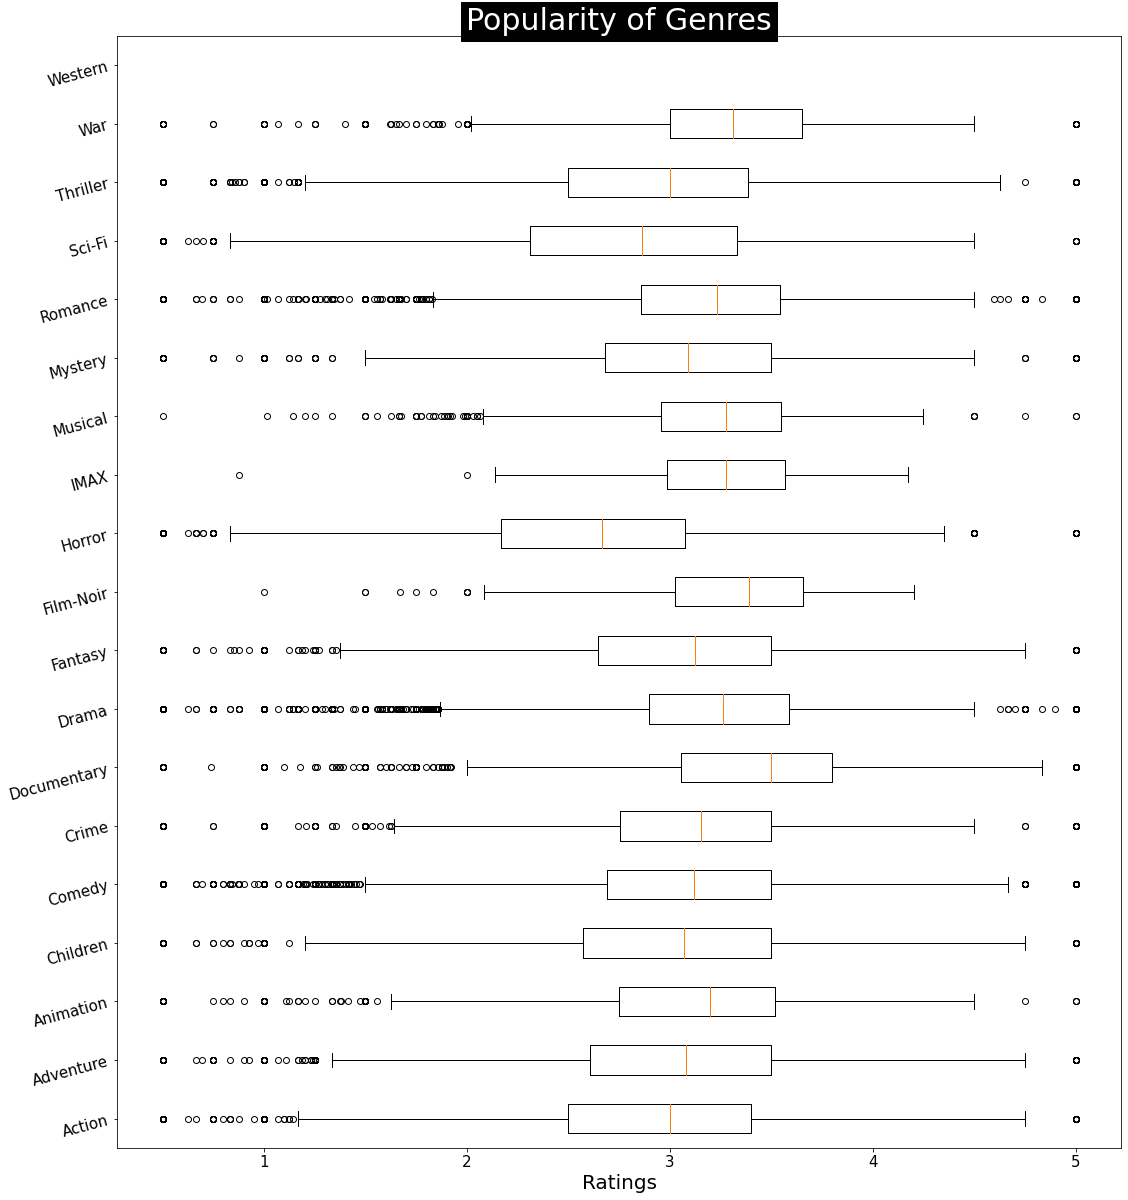

In [20]:
# creating boxplots
fig2 = plt.figure(1, figsize=(18,45))
ax3 = fig2.add_subplot(2,1,2)
y_label = genre_dict.keys()
print(y_label)
y_axis = [i for i,k in enumerate(genre_dict.keys())]
plt.yticks(rotation=15, fontsize = 15)
plt.xticks(fontsize = 15)
#plt.yticks(y_axis, y_label)
plt.xlabel("Ratings", fontsize = 20)
ax3.boxplot(list(genre_dict.values()), vert=False)
ax3.set_yticklabels(y_label)
plt.title("Popularity of Genres",bbox={'facecolor':'k', 'pad':5},color='w',fontsize = 30)
plt.show()

Relationship between year and rating of a movie

In [21]:
# we create a similar dictionary of year, ratings and make barplots
temp = [int(i) for i in movies['year'].unique()]
temp.sort()
mean_year_rating_dict = {str(int(round(i/10)*10)):[] for i in temp}
for i,row in ratings_and_movies.iterrows():
    #convert year to int and convert it to closest 10's digit
    year = int(round(int(row['year'])/10)*10)
    mean_year_rating_dict[str(year)].append(row['mean_rating'])



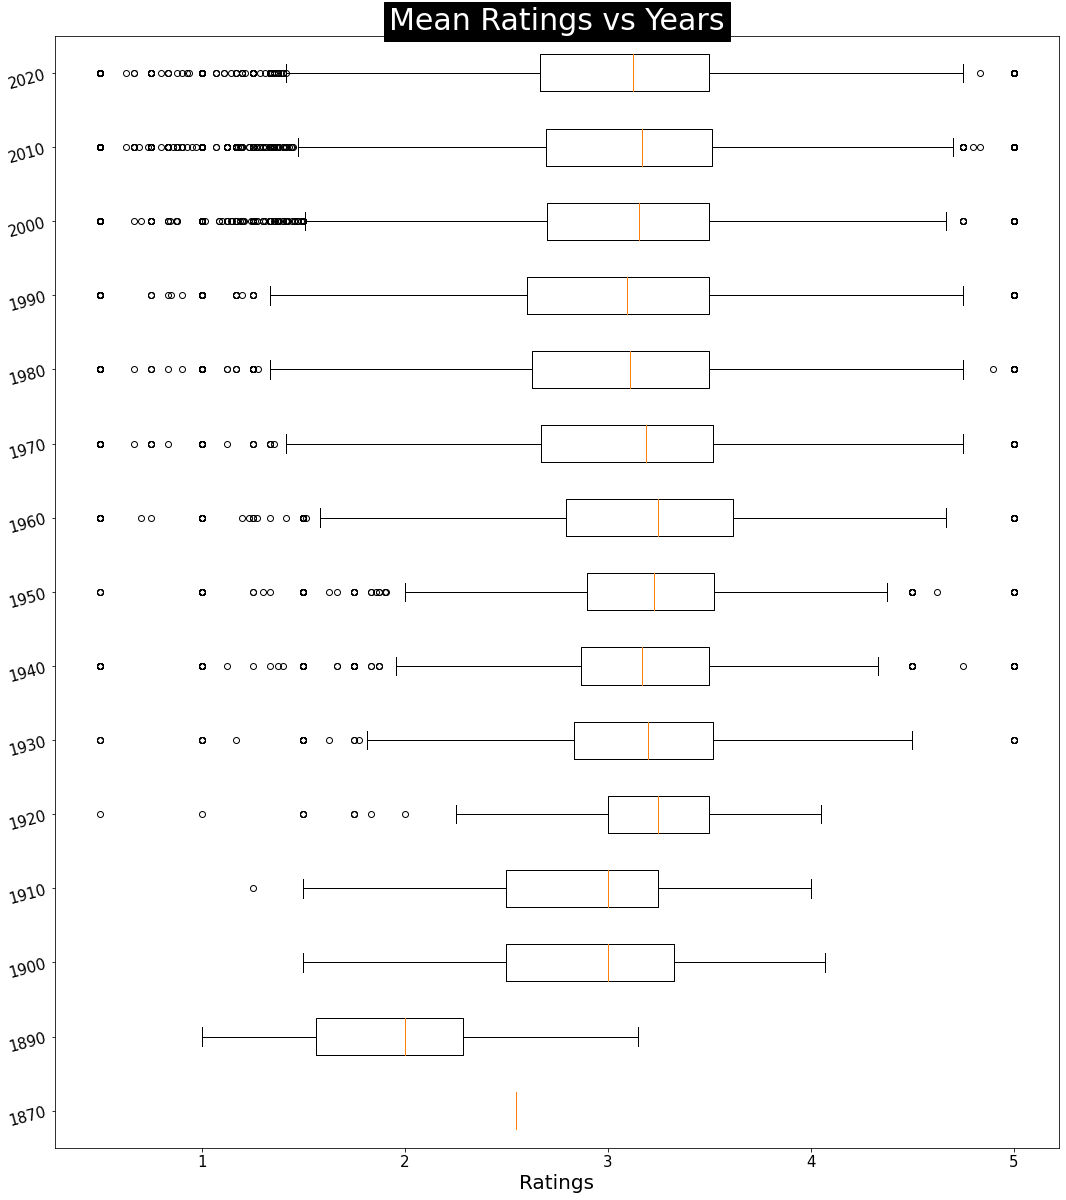

In [22]:
fig = plt.figure(1, figsize=(18,45))
ax = fig.add_subplot(2,1,2)
y_label = mean_year_rating_dict.keys()
y_axis = [i for i,k in enumerate(mean_year_rating_dict.keys())]
plt.yticks(rotation=15, fontsize = 15)
plt.xticks(fontsize = 15)
plt.xlabel("Ratings", fontsize = 20)
ax.boxplot(list(mean_year_rating_dict.values()), vert=False)
ax.set_yticklabels(y_label)

plt.title("Mean Ratings vs Years",bbox={'facecolor':'k', 'pad':5},color='w',fontsize = 30)
plt.show()

Conclusion
1. We see no changes in mean or median ratings over the years
2. The only takeaway from the above 2 graphs is that the spread of the ratings has increased, which can be a result of more ratings (or data availability)
3. Infact if we want to improve the efficiency of our model we can probably remove ratings that are 100 years old

Relationship between tag and ratings of a movie

To analyze this,we do the following
1. We should first analyze just the tag frequencies
2. For most frequents tags (top 5 or top 10) we find the most frequent ratings(top 5)
3. For most frequent rating (or each rating at 0.5 interval, whichever is larger), we get the most frequent (top 5) tags ( or top 10 tags in a larger dataset) 

In [23]:
tag_freq = ratings_and_tags['tag'].value_counts().sort_values(ascending=False).head(25)
tag_freq = dict(tag_freq)
print(tag_freq)

{'sci-fi': 8616, 'atmospheric': 6205, 'action': 5628, 'comedy': 5239, 'surreal': 5080, 'twist ending': 4687, 'funny': 4642, 'visually appealing': 4188, 'based on a book': 4169, 'dystopia': 3977, 'dark comedy': 3720, 'stylized': 3645, 'thought-provoking': 3630, 'psychology': 3520, 'fantasy': 3508, 'quirky': 3480, 'romance': 3416, 'classic': 3392, 'time travel': 3162, 'social commentary': 2979, 'adventure': 2744, 'space': 2742, 'dark': 2670, 'aliens': 2654, 'superhero': 2645}


[8616 6205 5628 5239 5080 4687 4642 4188 4169 3977 3720 3645 3630 3520
 3508 3480 3416 3392 3162 2979 2744 2742 2670 2654 2645]


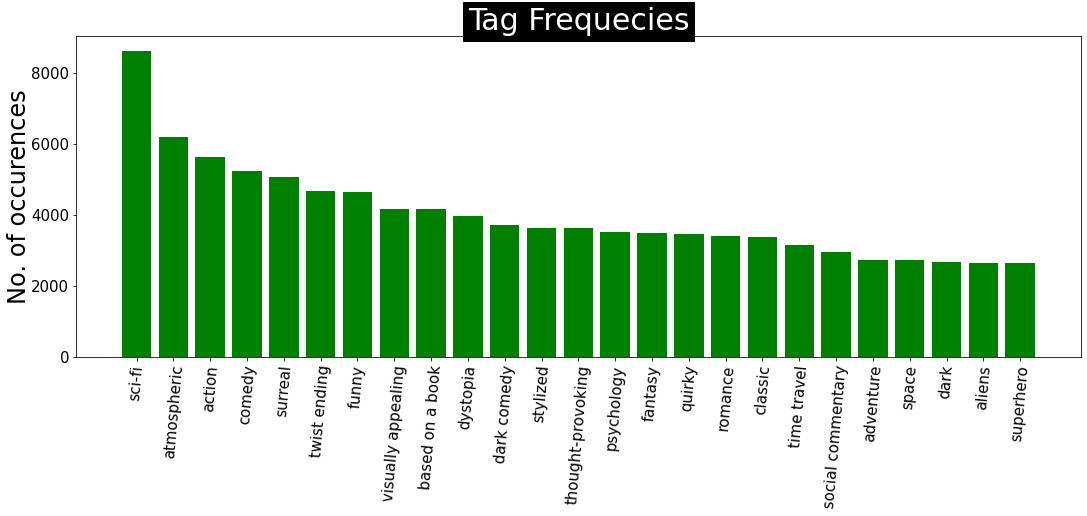

In [24]:
# Simply creating histogram for tag frequecies
tag_freq = ratings_and_tags['tag'].value_counts().sort_values(ascending=False).head(25)
fig = plt.figure(1, figsize=(18,13))
ax = fig.add_subplot(2,1,2)
y_axis = tag_freq.values
print(y_axis)
x_axis = [i for i,k in enumerate(tag_freq.keys())]
x_label = tag_freq.keys()
plt.xticks(rotation=85, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(x_axis, x_label)
plt.ylabel("No. of occurences", fontsize = 24, labelpad = 0)
ax.bar(x_axis, y_axis, align = 'center', color='g')
plt.title("Tag Frequecies",bbox={'facecolor':'k', 'pad':5},color='w',fontsize = 30)
plt.show()

In [25]:
# Tagwise rating frequency
tag_freq = ratings_and_tags['tag'].value_counts()
print("List of top 10 frequent tags", list(tag_freq.keys())[0:10])
print("==========================================================")
tag_rating_freq = ratings_and_tags[ratings_and_tags['tag'].isin(list(tag_freq.keys())[0:10])]
tag_rating_freq = tag_rating_freq.groupby(['tag','rating'])['rating'].count().reset_index(name='Count')
tag_rating_freq = tag_rating_freq.sort_values(ascending=[True,False], by=['tag','Count'], ignore_index=True)
print("List for top 10 tags and their ratings")
print(tag_rating_freq)


List of top 10 frequent tags ['sci-fi', 'atmospheric', 'action', 'comedy', 'surreal', 'twist ending', 'funny', 'visually appealing', 'based on a book', 'dystopia']
List for top 10 tags and their ratings
                   tag  rating  Count
0               action     4.0   1346
1               action     5.0   1173
2               action     3.5    953
3               action     4.5    931
4               action     3.0    618
..                 ...     ...    ...
95  visually appealing     2.5    117
96  visually appealing     2.0     75
97  visually appealing     1.5     28
98  visually appealing     1.0     14
99  visually appealing     0.5     12

[100 rows x 3 columns]


In [26]:
# Rating wise tag frequency
rating_freq = ratings_and_tags['rating'].value_counts()
print("List of top 5 frequent ratings", list(rating_freq.keys())[0:5])
print("==========================================================")

# Finding n largest for a combination of columns (rating, tag here)
# First find the count based on unique (rating, tag) combination 
rating_tag_freq = ratings_and_tags[ratings_and_tags['rating'].isin(list(rating_freq.keys())[0:5])]
rating_tag_freq = rating_tag_freq.groupby(['rating','tag'])['tag'].count().reset_index(name='Count')

# Now for each rating create a new dataframe based on first column and then do nlargest over the rest
result = pd.DataFrame()
for rating in list(rating_freq.keys())[0:5]:
    subset = rating_tag_freq.query("rating == @rating").sort_values(ascending=False, by='Count', ignore_index=True)
    subset = subset.head(10)
    if result.empty:
        result = subset 
    else:
        result = pd.concat([result, subset], axis=0)
result = result.reset_index(drop=True)
print("List for top 10 ratings and their tags")
print(result)

List of top 5 frequent ratings [4.0, 5.0, 4.5, 3.5, 3.0]
List for top 10 ratings and their tags
    rating                 tag  Count
0      4.0              sci-fi   2092
1      4.0         atmospheric   1506
2      4.0              action   1346
3      4.0              comedy   1284
4      4.0               funny   1283
5      4.0        twist ending   1158
6      4.0             surreal   1114
7      4.0     based on a book   1003
8      4.0  visually appealing    997
9      4.0            dystopia    970
10     5.0              sci-fi   2191
11     5.0         atmospheric   1985
12     5.0             surreal   1730
13     5.0        twist ending   1462
14     5.0   thought-provoking   1407
15     5.0             classic   1270
16     5.0          psychology   1227
17     5.0              comedy   1220
18     5.0         dark comedy   1201
19     5.0              action   1173
20     4.5              sci-fi   1570
21     4.5         atmospheric   1397
22     4.5             surreal

Conclusion
1. From the above we can see that high frequency tags also have higher ratings
2. The data for lower ratings is also lower in frequency
3. This means our recommender system should work better for movies that have better ratings, which should be our goal.
4. We could also provide users with tag suggestion from the above analysis which will further enrich our data

Relationship between tag + genre and ratings of a movie
1. First we analyze genre and tag relationship, i.e. Does a tag have closer relationship to a genre?
2. Then we visualize the contribution of tags and genre combination on ratings. For this we will only use 5 topmost frequent ratings

In [27]:
# Genre Tag analysis
# Select top 10 Genres only
genres = movies.iloc[:,4:29].sum().sort_values(ascending=False)
genres = set(genres.keys()[0:10])
genre_tag_df = pd.DataFrame() 
for genre in genres:
    subset = tags_and_movies[tags_and_movies[genre] == 1]
    subset['genre'] = genre
    subset = subset.groupby(['genre','tag'])['tag'].count().reset_index(name='Count')
    subset = subset.sort_values(ascending=False, by='Count', ignore_index=True).head(10)
    if genre_tag_df.empty:
        genre_tag_df = subset
    else:
        genre_tag_df = pd.concat([genre_tag_df, subset], axis=0)
            
genre_tag_df = genre_tag_df.reset_index(drop=True)
genre_tag_df

,genre,tag,Count
0,Sci-Fi,sci-fi,9243
1,Sci-Fi,dystopia,3904
2,Sci-Fi,space,2942
3,Sci-Fi,time travel,2793
4,Sci-Fi,aliens,2759
...,...,...,...
95,Horror,murder,809
96,Horror,vampires,760
97,Horror,twist ending,706
98,Horror,aliens,704


The above results show us overlap between tags and genres. For instance thriller movies are associated with tags such as "atmospheric" and " suspense"

Now we are to do above analysis for each of the most frequent ratings. This will tell us if a single genre with a specific tag will actually result in this genre

In [28]:
# frequent ratings are calculated in rating_freq
rating_genre_tag_df = pd.DataFrame()
for rating in list(rating_freq.keys())[0:5]:
    for genre in genres:
        subset = combined[(combined[genre] == 1) & (combined['rating'] == rating)]
        subset['genre'] = genre
        subset = subset.groupby(['rating','genre','tag'])['tag'].count().reset_index(name='Count')
        subset = subset.sort_values(ascending=False, by='Count', ignore_index=True).head(10)
 #       print(subset)
        if rating_genre_tag_df.empty:
            rating_genre_tag_df = subset
        else:
            rating_genre_tag_df = pd.concat([rating_genre_tag_df, subset], axis=0)
            
            
rating_genre_tag_df = rating_genre_tag_df.reset_index(drop=True)
rating_genre_tag_df


,rating,genre,tag,Count
0,4.0,Sci-Fi,sci-fi,2059
1,4.0,Sci-Fi,dystopia,879
2,4.0,Sci-Fi,time travel,659
3,4.0,Sci-Fi,space,636
4,4.0,Sci-Fi,aliens,607
...,...,...,...,...
495,3.0,Horror,disturbing,73
496,3.0,Horror,slasher,73
497,3.0,Horror,sci-fi,72
498,3.0,Horror,aliens,67


In [ ]:
# Visualization of the relationship
fig,ax = plt.subplots(len(rating_genre_tag_df['rating'].unique()), 1, figsize=(12,50))
colors = ['red', 'blue', 'green', 'orange', 'black']
i = 0
for rating in rating_genre_tag_df['rating'].unique():
    subset = rating_genre_tag_df[rating_genre_tag_df['rating'] == rating]
    subset = subset.sort_values(ascending=False, by='Count',ignore_index=True).head(10)
    x = subset['tag']
    y = subset['genre']
    s= subset['Count']*20
    ax[i].scatter(x,y,s,c=colors[i])
    ax[i].set_title('Genre vs Tag Frequencies for rating ' + str(rating))
    i = i + 1

plt.subplots_adjust(hspace=0.5)
plt.show()

Conclusion
1. From the above we can see how the given tag and genre we get some idea of ratings
2. Now if the ratings are at a higher end we would prefer to recommend those movies to our customers

User based analysis.

Here we divide the ratings into 2 segments. High ratings(3-5) and low ratings(0-2.5)
and for each user we find

**Recommendation system**

Which recommender system to use?

1. If we use collabrative filtering recommender system, we might have lack of data for a user limiting recommendations. Beside this we do not have data for measuring similarity between users
2. Content based recommendation system is a good idea here, since we have parameters like tag, genre and year which affect the ratings of the movies.

## Collabrative Filtering Recommendation System

Here are the steps that we are going to follow to build this recommendation system
1. We used a combined dataset which includes movies, users ,ratings and tags and then split it into test and train dataset in 80-20 dataset
2. We clean data based on analysis i.e. remove tags and genres that are infrequent from the dataset
3. We will use tdidf which uses a combination of genres and tags and do count vectorization
4. We use k-nearest nieghbors and along with cosine similarity to build a model

In [30]:
#tags.drop('timestamp', inplace=True)
#ratings.drop('timestamp', inplace=True)
movie_data = pd.merge(movies, tags, on="movieId", how="left")
movie_data = pd.merge(movie_data, ratings, on=["movieId", "userId"], how="inner")

# Display the combined dataset
print(movie_data.head())

   movieId             title                                       genres  \
0        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
1        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
2        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
3        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
4        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   

   year  Action  Adventure  Animation  Children  Comedy  Crime  ...  Romance  \
0  1995       0          1          1         1       1      0  ...        0   
1  1995       0          1          1         1       1      0  ...        0   
2  1995       0          1          1         1       1      0  ...        0   
3  1995       0          1          1         1       1      0  ...        0   
4  1995       0          1          1         1       1      0  ...        0   

   Sci-Fi  Thriller  War  Western  userId          tag  

In [50]:
tag_counts = movie_data['tag'].value_counts()
tag_threshold = 120
movie_data = movie_data[movie_data['tag'].apply(lambda x: tag_counts[x] >= tag_threshold)]
print(tag_counts.tail(200))

witch                       283
David Fincher               282
great dialogue              282
dystopic future             281
dance                       280
                           ... 
art                         192
beautiful cinematography    190
DVD-RAM                     190
lgbt                        185
propaganda                  169
Name: tag, Length: 200, dtype: int64


In [46]:
genre_counts = movie_data['genres'].str.split('|', expand=True).stack().value_counts()
genre_threshold = 10000
insig_genre = genre_counts[genre_counts<genre_threshold].index
#insig_genre
print(genre_counts.tail(20))

Drama          229990
Thriller       147526
Action         139638
Comedy         121825
Sci-Fi         121422
Adventure      100974
Crime           84551
Romance         73866
Fantasy         57962
Mystery         57489
Horror          43554
IMAX            36063
Animation       32270
Children        24517
War             20771
Musical         11913
Film-Noir        6777
Documentary      5421
Western          4416
dtype: int64


In [47]:
def all_genres_insig(genres):
    for genre in genres.split('|'):
        if genre not in insig_genre:
            return False
    return True

# Remove entries with only insignificant genres
#movie_data = movie_data[~movie_data['genres'].apply(all_genres_insig)]


In [51]:
# create feature vectors for each movie using tags and genres and year
vectorizer = TfidfVectorizer(strip_accents='unicode', lowercase=True, analyzer='word', 
                             ngram_range=(1, 2), stop_words='english')
X = vectorizer.fit_transform(movie_data['tag'] + ' ' + movie_data['genres'] + ' ' + movie_data['year'])
y = movie_data['rating']

# reset the indices of the data
movie_data = movie_data.reset_index(drop=True)

# split the data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# define the k value for the kNN algorithm
k = 5

knn = KNeighborsRegressor(n_neighbors=k, metric='cosine')
knn.fit(X_train, y_train)


KNeighborsRegressor(metric='cosine')

In [53]:
# predict the rating for each movie in the test dataset
y_pred = knn.predict(X_test)

# calculate the RMSE score
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

# calculate the precision, recall, and F1 score for a rating threshold of 3.5
threshold = 3.5
y_pred_binary = np.where(y_pred >= threshold, 1, 0)
y_test_binary = np.where(y_test >= threshold, 1, 0)
tp = np.sum((y_pred_binary == 1) & (y_test_binary == 1))
fp = np.sum((y_pred_binary == 1) & (y_test_binary == 0))
fn = np.sum((y_pred_binary == 0) & (y_test_binary == 1))
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

RMSE: 0.9584059719950586
Precision: 0.8429522976518873
Recall: 0.8668170308154257
F1 Score: 0.854718113845986


In [ ]:
print(rmse)
print(precision)
print(recall)
print(f1_score)